In [1]:
# =========================================================
# Heterogeneous long term effects of Project STAR
#
# =========================================================

# -----------------------
# Imports & configuration
# -----------------------
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
import time

# Limit BLAS/OpenMP threads to avoid oversubscription when joblib/pytorch also parallelize
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

from threadpoolctl import threadpool_limits
threadpool_limits(1)

from sklearn.linear_model import LogisticRegression

# RKHS
from nnpiv.rkhs import ApproxRKHSIVCV

# NN/AGMM 
import torch
import torch.nn as nn
from nnpiv.neuralnet.agmm import AGMM

# Linear
from nnpiv.tsls import tsls

# DML long-term
from nnpiv.semiparametrics import DML_longterm, DML_npiv


# -----------------------
# Reproducibility helpers
# -----------------------
def seed_everything(seed: int = 123) -> None:
    """Set seeds for reproducibility."""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(123)

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
try:
    torch.set_num_threads(1)
    torch.set_num_interop_threads(1)
except Exception:
    pass

# --------------------------------
# Paths & high-level configuration
# --------------------------------
DATA_PATH = "../data/data_star.csv"
OUTDIR = "../output/"  # where to save CSVs and PNGs
os.makedirs(OUTDIR, exist_ok=True)

OUTCOME_LIST = [f"z_score{g}" for g in range(3, 9)]  # z_score3 .. z_score8
LOGIT_KW = dict(max_iter=2000)

# -----------------------
# Plotting configuration
# -----------------------
sns.set_style("white")
sns.set_palette("Set2")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True

# ---------------
# Model builders
# ---------------
def build_rkhs_pair():
    """Return fresh (m1, m2) RKHS models for each outcome to avoid state leakage."""
    m1 = ApproxRKHSIVCV(kernel_approx="nystrom", n_components=400,
                        kernel="rbf", gamma=0.001, delta_scale="auto",
                        delta_exp=0.4, alpha_scales=np.geomspace(1, 10000, 10), cv=10)
    m2 = ApproxRKHSIVCV(kernel_approx="nystrom", n_components=400,
                        kernel="rbf", gamma=0.001, delta_scale="auto",
                        delta_exp=0.4, alpha_scales=np.geomspace(1, 10000, 10), cv=10)
    return m1, m2

def build_nn_pair(p: float = 0.10, n_hidden: int = 100):
    """Return fresh (m1, m2) AGMM models for each outcome."""
    def _get_learner(n_t):
        return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                             nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    def _get_adversary(n_z):
        return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                             nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    m1 = AGMM(_get_learner(2), _get_adversary(2))
    m2 = AGMM(_get_learner(1), _get_adversary(1))
    fitargs = {
        "n_epochs": 500, "bs": 100,
        "learner_lr": 1e-4, "adversary_lr": 1e-4,
        "learner_l2": 1e-3, "adversary_l2": 1e-4,
        "device": DEVICE,
    }
    opts = {"burnin": 400}
    nn_flags = [True, True]
    return (m1, m2), fitargs, opts, nn_flags

# --------------
# Core routines
# --------------
def run_longterm_suite_single_Y(
    Y: np.ndarray,
    D: np.ndarray,
    S: np.ndarray,
    G: np.ndarray,
    ones: np.ndarray,
    mode: str,  # "rkhs" or "nn"
):
    """
    Run the three estimators for a single outcome:
      - Long-term latent unconfounded
      - Long-term surrogacy
      - Oracle (experimental NPIV)
    Returns: dict with coefficients/variances for each estimator.
    """
    # Build models fresh per outcome (avoid carrying fit state across outcomes)
    if mode == "rkhs":
        m1, m2 = build_rkhs_pair()
        dml_kwargs_common = dict(model1=[m1, m2], nn_1=[False, False], fitargs1=[None, None], opts={"lin_degree": 1})
    elif mode == "nn":
        (m1, m2), fitargs, opts, nn_flags = build_nn_pair()
        dml_kwargs_common = dict(model1=[m1, m2], nn_1=nn_flags, fitargs1=[fitargs, fitargs], opts=opts)
    else:
        raise ValueError("mode must be 'rkhs' or 'nn'")

    # Long-term (latent)
    dml_latent = DML_longterm(
        Y, D, S, G,
        longterm_model="latent_unconfounded",
        n_folds=5, n_rep=1, CHIM=False,
        prop_score=LogisticRegression(**LOGIT_KW),
        **dml_kwargs_common
    )
    coef_latent, var_latent, _ = dml_latent.dml()

    # Long-term (surrogacy)
    dml_surr = DML_longterm(
        Y, D, S, G,
        longterm_model="surrogacy",
        n_folds=5, n_rep=1, CHIM=False,
        prop_score=LogisticRegression(**LOGIT_KW),
        **dml_kwargs_common
    )
    coef_surr, var_surr, _ = dml_surr.dml()

    # Oracle (experimental arm only)
    idx_exp = np.where(G.reshape(-1) == 0)[0]
    Y_exp = Y[idx_exp]
    D_exp = D[idx_exp]
    ones_exp = ones[idx_exp]
    dml_oracle = DML_npiv(
        Y_exp, D_exp, ones_exp, ones_exp,
        estimator="MR",
        model1=tsls(),
        modelq1=tsls(),
        n_folds=5, n_rep=1, CHIM=False,
        prop_score=LogisticRegression(**LOGIT_KW),
    )
    coef_or, var_or, _ = dml_oracle.dml()

    return dict(
        coef_latent=float(np.atleast_1d(coef_latent)[0]),
        var_latent=float(np.atleast_1d(var_latent)[0]),
        coef_surr=float(np.atleast_1d(coef_surr)[0]),
        var_surr=float(np.atleast_1d(var_surr)[0]),
        coef_oracle=float(np.atleast_1d(coef_or)[0]),
        var_oracle=float(np.atleast_1d(var_or)[0]),
    )

def run_longterm_grid(
    df: pd.DataFrame,
    outcome_cols: list[str],
    D_col: str,
    S_col: str,
    G_col: str,
    subset_mask: np.ndarray | None,
    mode: str,  # "rkhs" or "nn"
):
    """
    Run the suite across multiple outcomes and return a tidy results DataFrame.
    If subset_mask is provided, rows with False are dropped consistently across all variables.
    """
    if subset_mask is not None:
        dff = df.loc[subset_mask].copy()
    else:
        dff = df

    # Assemble arrays
    D = dff[[D_col]].values
    S = dff[[S_col]].values
    G = dff[[G_col]].values
    ones = np.ones((len(dff), 1), dtype=float)

    rows = []
    for ycol in outcome_cols:
        Y = dff[[ycol]].values
        res = run_longterm_suite_single_Y(Y, D, S, G, ones, mode=mode)
        rows.append({
            "Y_value": ycol,
            "Coefficient Latent": res["coef_latent"],
            "Variance Latent": res["var_latent"],
            "Coefficient Surrogacy": res["coef_surr"],
            "Variance Surrogacy": res["var_surr"],
            "Coefficient Oracle": res["coef_oracle"],
            "Variance Oracle": res["var_oracle"],
            "n": len(dff),  # carry sample size for plotting SEs
        })
    return pd.DataFrame(rows)

# -----------
# Plot helper
# -----------
def plot_results(results: pd.DataFrame, title: str, out_png: str):
    """
    Errorbar plot across long-term horizons (z_score3..8).
    Uses 95% normal CIs: 1.96 * sqrt(var / n).
    """
    n = float(results["n"].iloc[0])  # same n for all rows in this result table
    x = np.arange(3, 9)  # horizons 3..8

    plt.figure(figsize=(7, 3))
    plt.errorbar(
        x - 0.1,
        results["Coefficient Oracle"],
        yerr=1.96 * np.sqrt(results["Variance Oracle"] / n),
        capthick=1.5, capsize=5, fmt="x", label="Oracle: STAR (D, Y)",
    )
    plt.errorbar(
        x,
        results["Coefficient Latent"],
        yerr=1.96 * np.sqrt(results["Variance Latent"] / n),
        capthick=1.5, capsize=5, fmt=".", label="Proposal: STAR (D, M) + NYC (D, M, Y)",
    )
    plt.errorbar(
        x + 0.1,
        results["Coefficient Surrogacy"],
        yerr=1.96 * np.sqrt(results["Variance Surrogacy"] / n),
        capthick=1.5, capsize=5, fmt="^", label="Proposal: STAR (D, M) + NYC (M, Y)",
    )

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, _: f"{val:.2f}"))
    plt.yticks([0, 0.05, 0.10, 0.15, 0.20, 0.25], fontsize=12)
    plt.axhline(y=0, color="black", linestyle="--", linewidth=1)
    sns.despine()

    plt.xticks(x, [str(i) for i in x], fontsize=18)
    plt.xlabel("Long term horizon", fontsize=18)
    plt.ylabel("Long term effect", fontsize=18)

    print(f"[PLOT] {title}")
    plt.legend(frameon=False, loc=(.4, .8), fontsize=13)
    plt.tight_layout()
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.show()
    print(f"Saved figure -> {out_png}")

@contextmanager
def timer(label: str):
    t0 = time.perf_counter()
    try:
        yield
    finally:
        dt = time.perf_counter() - t0
        mins, secs = divmod(dt, 60)
        print(f"[TIMING] {label} finished in {int(mins)}m {secs:05.2f}s")

# ---------- System / resource banner ----------
def print_system_resources():
    import sys, os, platform, datetime
    try:
        import psutil
    except Exception:
        psutil = None
    from threadpoolctl import threadpool_info
    import numpy as np
    import sklearn
    try:
        import torch
    except Exception:
        torch = None

    print("="*72)
    print(f"Session started: {datetime.datetime.now().isoformat(timespec='seconds')}")
    print(f"Python: {sys.version.split()[0]}  |  OS: {platform.system()} {platform.release()} ({platform.machine()})")
    # CPU / RAM
    logical = os.cpu_count()
    physical = None
    if psutil:
        try:
            physical = psutil.cpu_count(logical=False)
        except Exception:
            physical = None
    line = f"CPU cores: {logical}"
    if physical:
        line += f" (physical: {physical})"
    print(line)
    if psutil:
        try:
            mem_gb = psutil.virtual_memory().total / (1024**3)
            print(f"RAM: {mem_gb:.1f} GB")
        except Exception:
            pass

    # BLAS/OpenMP threading + libraries
    env_keys = ["OMP_NUM_THREADS","OPENBLAS_NUM_THREADS","MKL_NUM_THREADS","VECLIB_MAXIMUM_THREADS","NUMEXPR_NUM_THREADS"]
    env_summary = ", ".join([f"{k}={os.environ.get(k,'-')}" for k in env_keys])
    print(f"Thread env: {env_summary}")
    try:
        infos = threadpool_info()
        if infos:
            print("Threadpool libraries:")
            for lib in infos:
                libname = lib.get("internal_api", lib.get("prefix", ""))
                nthreads = lib.get("num_threads", "?")
                fname = lib.get("filename", "")
                print(f"  - {libname:8s}  threads={nthreads}  lib={os.path.basename(fname)}")
    except Exception:
        pass

    # Packages
    print(f"NumPy: {np.__version__}  |  scikit-learn: {sklearn.__version__}")

    # GPU (PyTorch)
    if torch is not None:
        cuda_ok = torch.cuda.is_available()
        print(f"PyTorch: {torch.__version__}  |  CUDA available: {cuda_ok}")
        if cuda_ok:
            ngpu = torch.cuda.device_count()
            print(f"GPUs: {ngpu}")
            for i in range(ngpu):
                name = torch.cuda.get_device_name(i)
                cap  = torch.cuda.get_device_capability(i)
                print(f"  - [{i}] {name}  capability={cap[0]}.{cap[1]}")
            try:
                torch.set_num_threads(1)
                torch.set_num_interop_threads(1)
            except Exception:
                pass
    else:
        print("PyTorch: not installed")

    print("="*72)

In [2]:
# Print system resources
print_system_resources()

Session started: 2025-09-03T22:17:48
Python: 3.10.18  |  OS: Linux 4.18.0-553.44.1.el8_10.x86_64 (x86_64)
CPU cores: 64 (physical: 64)
RAM: 503.0 GB
Thread env: OMP_NUM_THREADS=1, OPENBLAS_NUM_THREADS=1, MKL_NUM_THREADS=1, VECLIB_MAXIMUM_THREADS=1, NUMEXPR_NUM_THREADS=1
Threadpool libraries:
  - mkl       threads=1  lib=
  - openmp    threads=1  lib=
NumPy: 2.2.6  |  scikit-learn: 1.7.1
PyTorch: 2.5.0  |  CUDA available: True
GPUs: 4
  - [0] NVIDIA A100-SXM4-40GB MIG 3g.20gb  capability=8.0
  - [1] NVIDIA A100-SXM4-40GB MIG 3g.20gb  capability=8.0
  - [2] NVIDIA A100-SXM4-40GB MIG 3g.20gb  capability=8.0
  - [3] NVIDIA A100-SXM4-40GB MIG 3g.20gb  capability=8.0


Rep: 1


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Rep: 1


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 78.48it/s]


Rep: 1


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Rep: 1


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 95.94it/s]


Rep: 1


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Rep: 1


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 114.15it/s]


Rep: 1


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


Rep: 1


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 116.15it/s]


Rep: 1


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


Rep: 1


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 94.40it/s]


Rep: 1


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


Rep: 1


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 117.75it/s]


[TIMING] RKHS — Full Sample finished in 2m 25.95s
Saved RKHS -> ../output/longterm_star_rkhs.csv
[PLOT] RKHS — Full Sample


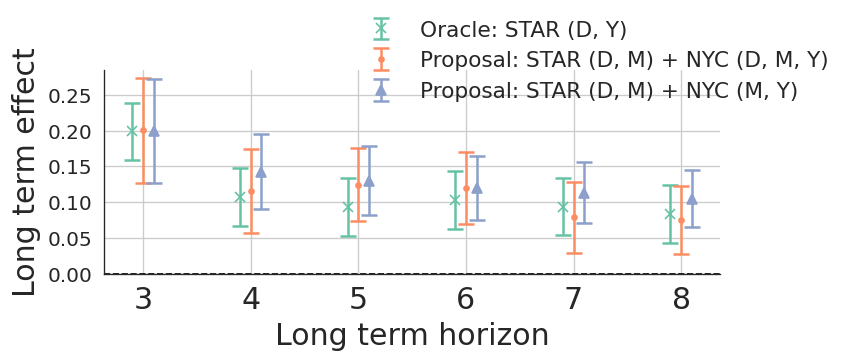

Saved figure -> ../output/plot_longterm_star_rkhs.png


In [3]:
# --------
# Run all
# --------
# 1) Load data once
df = pd.read_csv(DATA_PATH)

# Shared columns
D_col = "D"
S_col = "z_score3"     # mediator/surrogate at t=3
G_col = "G"

# ----------------------------
# A) RKHS — full sample
# ----------------------------
with timer("RKHS — Full Sample"):
    results_rkhs_full = run_longterm_grid(
        df=df,
        outcome_cols=OUTCOME_LIST,
        D_col=D_col, S_col=S_col, G_col=G_col,
        subset_mask=None,
        mode="rkhs",
    )
csv_rkhs_full = os.path.join(OUTDIR, "longterm_star_rkhs.csv")
results_rkhs_full.to_csv(csv_rkhs_full, index=False)
print(f"Saved RKHS -> {csv_rkhs_full}")
plot_results(results_rkhs_full, title="RKHS — Full Sample", out_png=os.path.join(OUTDIR, "plot_longterm_star_rkhs.png"))

Rep: 1


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Rep: 1


100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 96.46it/s]


Rep: 1


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


Rep: 1


100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 95.76it/s]


Rep: 1


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


Rep: 1


100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 115.16it/s]


Rep: 1


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


Rep: 1


100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 96.51it/s]


Rep: 1


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Rep: 1


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 97.35it/s]


Rep: 1


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


Rep: 1


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 91.74it/s]


[TIMING] RKHS — Subsample finished in 2m 23.14s
Saved RKHS (subsample) -> ../output/longterm_star_rkhs_subsample.csv
[PLOT] RKHS — Subsample (non-missing prior score)


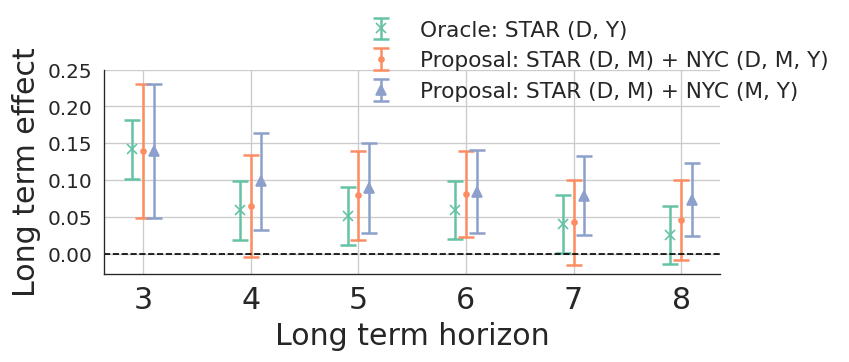

Saved figure -> ../output/plot_longterm_star_rkhs_subsample.png


In [4]:
# -------------------------------------------------------
# B) RKHS — subsample (drop rows with NaN on z_score_prior)
# -------------------------------------------------------
mask_prior = ~df["z_score_prior"].isna().values
with timer("RKHS — Subsample"):
    results_rkhs_sub = run_longterm_grid(
        df=df,
        outcome_cols=OUTCOME_LIST,
        D_col=D_col, S_col=S_col, G_col=G_col,
        subset_mask=mask_prior,
        mode="rkhs",
    )
csv_rkhs_sub = os.path.join(OUTDIR, "longterm_star_rkhs_subsample.csv")
results_rkhs_sub.to_csv(csv_rkhs_sub, index=False)
print(f"Saved RKHS (subsample) -> {csv_rkhs_sub}")
plot_results(results_rkhs_sub, title="RKHS — Subsample (non-missing prior score)", out_png=os.path.join(OUTDIR, "plot_longterm_star_rkhs_subsample.png"))

Rep: 1


100%|██████████| 5/5 [11:24<00:00, 136.85s/it]


Rep: 1


100%|██████████| 5/5 [10:31<00:00, 126.35s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 102.49it/s]


Rep: 1


100%|██████████| 5/5 [10:50<00:00, 130.07s/it]


Rep: 1


100%|██████████| 5/5 [10:30<00:00, 126.19s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 129.04it/s]


Rep: 1


100%|██████████| 5/5 [10:47<00:00, 129.55s/it]


Rep: 1


100%|██████████| 5/5 [10:36<00:00, 127.37s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 127.90it/s]


Rep: 1


100%|██████████| 5/5 [11:33<00:00, 138.72s/it]


Rep: 1


100%|██████████| 5/5 [10:45<00:00, 129.19s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 129.68it/s]


Rep: 1


100%|██████████| 5/5 [11:32<00:00, 138.45s/it]


Rep: 1


100%|██████████| 5/5 [11:09<00:00, 133.99s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 102.15it/s]


Rep: 1


100%|██████████| 5/5 [11:23<00:00, 136.77s/it]


Rep: 1


100%|██████████| 5/5 [10:35<00:00, 127.04s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 129.26it/s]


[TIMING] AGMM — Full Sample finished in 131m 43.22s
Saved NN -> ../output/longterm_star_nn.csv
[PLOT] NN (AGMM) — Full Sample


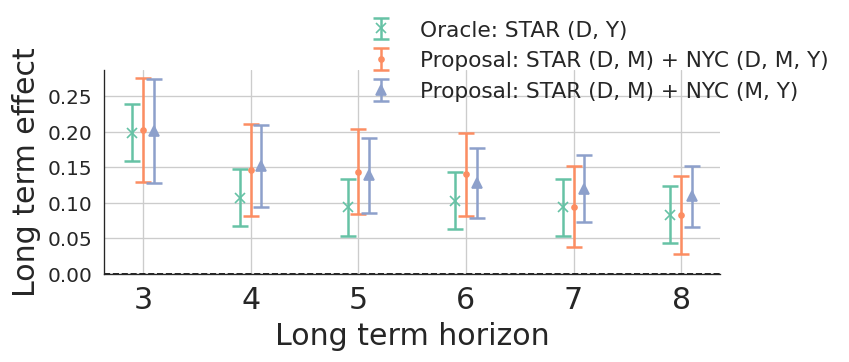

Saved figure -> ../output/plot_longterm_star_nn.png


In [5]:
# ----------------------------
# C) NN (AGMM) — full sample
# ----------------------------
with timer("AGMM — Full Sample"):
    results_nn_full = run_longterm_grid(
        df=df,
        outcome_cols=OUTCOME_LIST,
        D_col=D_col, S_col=S_col, G_col=G_col,
        subset_mask=None,
    mode="nn",
    )
csv_nn_full = os.path.join(OUTDIR, "longterm_star_nn.csv")
results_nn_full.to_csv(csv_nn_full, index=False)
print(f"Saved NN -> {csv_nn_full}")
plot_results(results_nn_full, title="NN (AGMM) — Full Sample", out_png=os.path.join(OUTDIR, "plot_longterm_star_nn.png"))

Rep: 1


100%|██████████| 5/5 [09:37<00:00, 115.46s/it]


Rep: 1


100%|██████████| 5/5 [09:21<00:00, 112.30s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 102.86it/s]


Rep: 1


100%|██████████| 5/5 [09:43<00:00, 116.64s/it]


Rep: 1


100%|██████████| 5/5 [09:19<00:00, 111.84s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 101.19it/s]


Rep: 1


100%|██████████| 5/5 [09:41<00:00, 116.34s/it]


Rep: 1


100%|██████████| 5/5 [09:22<00:00, 112.54s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 103.06it/s]


Rep: 1


100%|██████████| 5/5 [09:37<00:00, 115.43s/it]


Rep: 1


100%|██████████| 5/5 [09:51<00:00, 118.26s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 102.43it/s]


Rep: 1


100%|██████████| 5/5 [09:43<00:00, 116.61s/it]


Rep: 1


100%|██████████| 5/5 [09:20<00:00, 112.07s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 122.15it/s]


Rep: 1


100%|██████████| 5/5 [09:37<00:00, 115.56s/it]


Rep: 1


100%|██████████| 5/5 [09:32<00:00, 114.59s/it]


Rep: 1


100%|██████████| 5/5 [00:00<00:00, 126.87it/s]


[TIMING] AGMM — Subsample finished in 114m 48.56s
Saved NN (subsample) -> ../output/longterm_star_nn_subsample.csv
[PLOT] NN (AGMM) — Subsample (non-missing prior score)


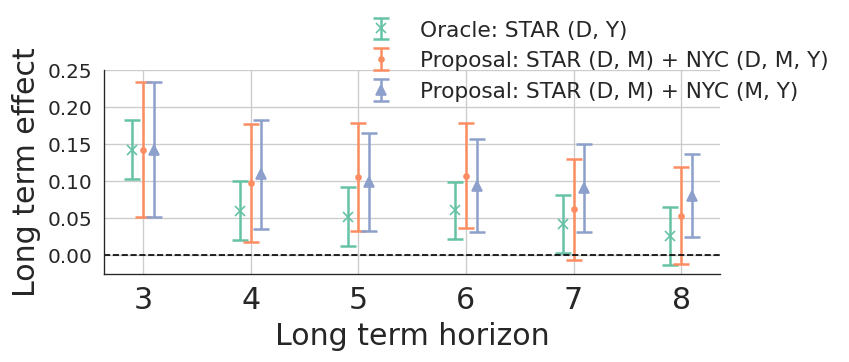

Saved figure -> ../output/plot_longterm_star_nn_subsample.png


In [6]:
# -------------------------------------------------------
# D) NN (AGMM) — subsample (same mask as RKHS subsample)
# -------------------------------------------------------
with timer("AGMM — Subsample"):
    results_nn_sub = run_longterm_grid(
        df=df,
        outcome_cols=OUTCOME_LIST,
        D_col=D_col, S_col=S_col, G_col=G_col,
        subset_mask=mask_prior,
        mode="nn",
    )
csv_nn_sub = os.path.join(OUTDIR, "longterm_star_nn_subsample.csv")
results_nn_sub.to_csv(csv_nn_sub, index=False)
print(f"Saved NN (subsample) -> {csv_nn_sub}")
plot_results(results_nn_sub, title="NN (AGMM) — Subsample (non-missing prior score)", out_png=os.path.join(OUTDIR, "plot_longterm_star_nn_subsample.png"))

In [13]:

# =========================================================
#    Heterogeneous (CATE) figures over prior ability
# =========================================================

def _bw_silverman_1d(V: np.ndarray) -> float:
    IQR = np.percentile(V, 75, axis=0) - np.percentile(V, 25, axis=0)
    A = np.minimum(np.std(V, axis=0), IQR / 1.349)
    n = V.shape[0]
    return (0.9 * np.asarray(A).squeeze() * (n ** -0.2)).item()

def run_heterogeneous_grid(
    df: pd.DataFrame,
    outcome_cols: list[str],
    mode: str,                 # "rkhs" or "nn"
    loc_kernel: str = "epa",
    percentiles = np.arange(5, 100, 10),
):
    """
    For each outcome, compute heterogeneous long-term effects across percentiles of prior ability.
    Uses DML_longterm with (V, v_values) for Surrogacy & Latent, and Oracle via experimental arm
    with weights built by DML_longterm._localization (same kernel).
    Produces one plot per outcome and returns a tidy DataFrame of all results.
    """
    # Subsample to non-missing prior score
    mask = ~df["z_score_prior"].isna().values
    dff = df.loc[mask].copy()

    # Core arrays
    D = dff[["D"]].values
    S = dff[["z_score3"]].values
    G = dff[["G"]].values
    V = dff[["z_score_prior"]].values
    prop = LogisticRegression(**LOGIT_KW)

    # Choose backend
    if mode == "rkhs":
        m1, m2 = build_rkhs_pair()
        dml_common = dict(model1=[m1, m2], nn_1=[False, False], fitargs1=[None, None], opts={"lin_degree": 1})
    elif mode == "nn":
        (m1, m2), fitargs, opts, nn_flags = build_nn_pair()
        dml_common = dict(model1=[m1, m2], nn_1=nn_flags, fitargs1=[fitargs, fitargs], opts=opts)
    else:
        raise ValueError("mode must be 'rkhs' or 'nn'")

    # Percentile grid on V
    v_values = np.percentile(V, percentiles)

    all_rows = []

    for ycol in outcome_cols:
        Y = dff[[ycol]].values

        # DML_longterm with localization inputs (V, v_values); include_V=False so V only localizes
        dml_s = DML_longterm(
            Y, D, S, G,
            X1=None, V=V, v_values=v_values, include_V=False,
            estimator="MR", loc_kernel=loc_kernel,
            longterm_model="surrogacy",
            n_folds=5, n_rep=1, CHIM=False, prop_score=prop,
            **dml_common
        )
        theta_s, cov_s, ci_s = dml_s.dml()
        var_s = np.diag(cov_s)

        dml_lu = DML_longterm(
            Y, D, S, G,
            X1=None, V=V, v_values=v_values, include_V=False,
            estimator="MR", loc_kernel=loc_kernel,
            longterm_model="latent_unconfounded",
            n_folds=5, n_rep=1, CHIM=False, prop_score=prop,
            **dml_common
        )
        theta_lu, cov_lu, ci_lu = dml_lu.dml()
        var_lu = np.diag(cov_lu)

        # Oracle (experimental arm) with SAME kernel weights via class method
        idx_exp = np.where(G.reshape(-1) == 0)[0]
        Y_exp, D_exp, V_exp = Y[idx_exp], D[idx_exp], V[idx_exp]
        ones_exp = np.ones_like(Y_exp)

        bw = _bw_silverman_1d(V_exp)
        ell_cols = [dml_s._localization(V_exp, float(v), bw) for v in v_values]
        ell_stack = np.column_stack(ell_cols)

        theta_or, var_or, l_or, u_or = [], [], [], []
        for j in range(ell_stack.shape[1]):
            Yw = Y_exp * ell_stack[:, [j]]
            dml_or = DML_npiv(
                Yw, D_exp, ones_exp, ones_exp,
                estimator="MR", ci_type="pointwise",
                model1=tsls(), modelq1=tsls(),
                n_folds=5, n_rep=1, CHIM=False, prop_score=prop,
                verbose=False, opts={"lin_degree": 1}, random_seed=123
            )
            th, va, ci = dml_or.dml()
            theta_or.append(float(np.atleast_1d(th)[0]))
            var_or.append(float(np.atleast_1d(va)[0]))
            l_or.append(float(ci[0]))
            u_or.append(float(ci[1]))

        theta_or = np.array(theta_or)
        var_or = np.array(var_or)
        ci_or = np.column_stack([l_or, u_or])

        # Collect rows
        for k, p in enumerate(percentiles):
            all_rows.append({
                "Outcome": ycol,
                "Percentile": p,
                "Theta_Oracle": theta_or[k],
                "Variance_Oracle": var_or[k],
                "Lower_CI_Oracle": ci_or[k, 0],
                "Upper_CI_Oracle": ci_or[k, 1],
                "Theta_Surrogate": theta_s[k],
                "Variance_Surrogate": var_s[k],
                "Lower_CI_Surrogate": ci_s[k, 0],
                "Upper_CI_Surrogate": ci_s[k, 1],
                "Theta_Latent_Unconfounded": theta_lu[k],
                "Variance_Latent_Unconfounded": var_lu[k],
                "Lower_CI_Latent_Unconfounded": ci_lu[k, 0],
                "Upper_CI_Latent_Unconfounded": ci_lu[k, 1],
            })

        # Plot per outcome (print label instead of title)
        plt.figure(figsize=(7, 3))
        sns.set_style("white")
        sns.set_palette("Set2")

        yhat_o = theta_or
        yerr_o = [yhat_o - ci_or[:, 0], ci_or[:, 1] - yhat_o]
        plt.errorbar(percentiles, yhat_o, yerr=yerr_o, marker="x", capsize=5, label="Oracle: STAR (D, Y)")

        shift = 0.5
        yhat_lu = theta_lu
        yerr_lu = [yhat_lu - ci_lu[:, 0], ci_lu[:, 1] - yhat_lu]
        plt.errorbar(np.array(percentiles) + shift, yhat_lu, yerr=yerr_lu, marker=".", capsize=5,
                     label="Proposal: STAR (D, M) + NYC (D, M, Y)")

        yhat_s = theta_s
        yerr_s = [yhat_s - ci_s[:, 0], ci_s[:, 1] - yhat_s]
        plt.errorbar(np.array(percentiles) - shift, yhat_s, yerr=yerr_s, marker="^", capsize=5,
                     label="Proposal: STAR (D, M) + NYC (M, Y)")

        plt.axhline(y=0, color="black", linestyle="--", linewidth=1)
        plt.xlabel("Prior ability")
        plt.ylabel("Long term effect")
        sns.despine()
        plt.tight_layout()

        out_png = os.path.join(OUTDIR, f"plot_heterogeneous_{ycol}_{loc_kernel}_{mode}.png")
        # Print which plot instead of setting a title:
        print(f"[PLOT] Heterogeneous — {mode.upper()} — Outcome: {ycol} -> {out_png}")
        plt.savefig(out_png, dpi=600, bbox_inches="tight")
        plt.show()
        print(f"Saved figure -> {out_png}")

    res = pd.DataFrame(all_rows)
    out_csv = os.path.join(OUTDIR, f"heterogeneous_star_{mode}.csv")
    res.to_csv(out_csv, index=False)
    print(f"Saved heterogeneous ({mode}) -> {out_csv}")
    return res


Rep: 1


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


Rep: 1


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


[PLOT] Heterogeneous — RKHS — Outcome: z_score3 -> ../output/plot_heterogeneous_z_score3_gau_rkhs.png


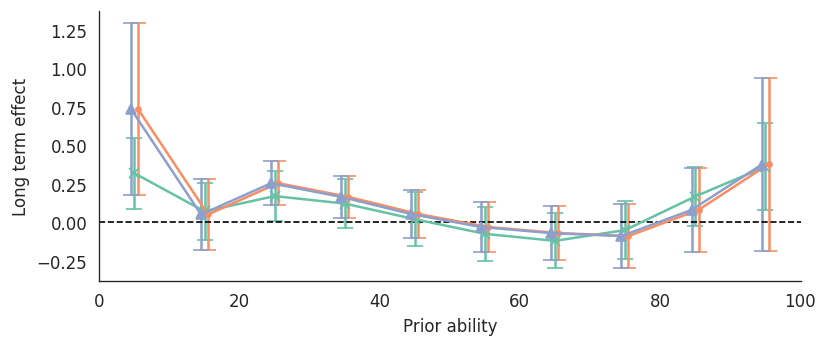

Saved figure -> ../output/plot_heterogeneous_z_score3_gau_rkhs.png
Rep: 1


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Rep: 1


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


[PLOT] Heterogeneous — RKHS — Outcome: z_score4 -> ../output/plot_heterogeneous_z_score4_gau_rkhs.png


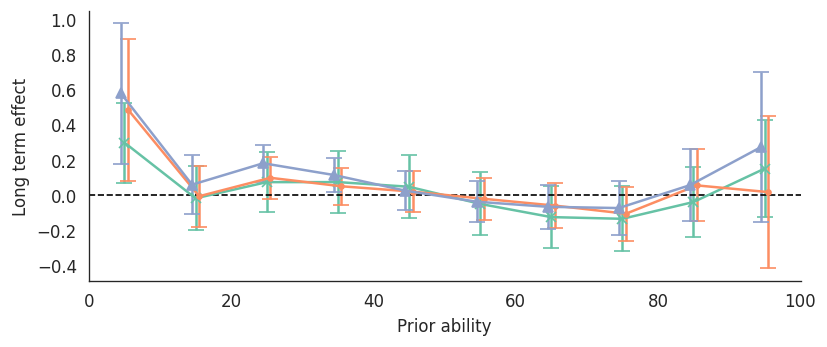

Saved figure -> ../output/plot_heterogeneous_z_score4_gau_rkhs.png
Rep: 1


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Rep: 1


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


[PLOT] Heterogeneous — RKHS — Outcome: z_score5 -> ../output/plot_heterogeneous_z_score5_gau_rkhs.png


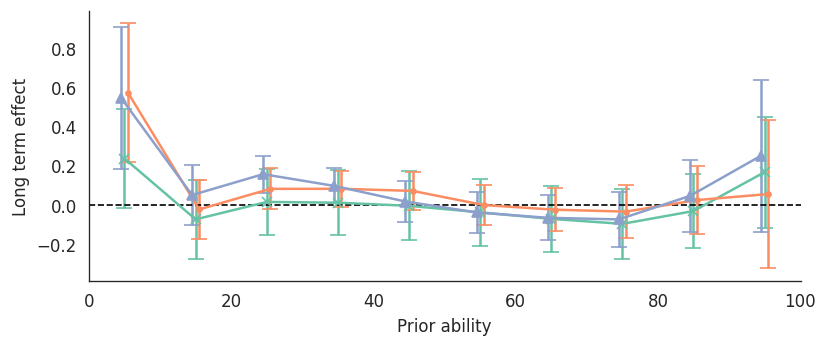

Saved figure -> ../output/plot_heterogeneous_z_score5_gau_rkhs.png
Rep: 1


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Rep: 1


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


[PLOT] Heterogeneous — RKHS — Outcome: z_score6 -> ../output/plot_heterogeneous_z_score6_gau_rkhs.png


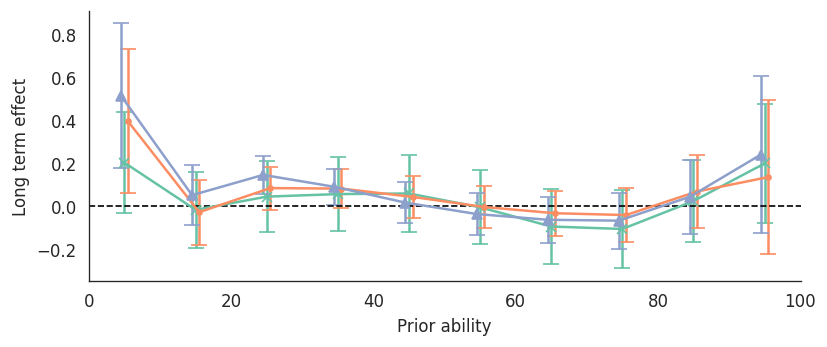

Saved figure -> ../output/plot_heterogeneous_z_score6_gau_rkhs.png
Rep: 1


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Rep: 1


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


[PLOT] Heterogeneous — RKHS — Outcome: z_score7 -> ../output/plot_heterogeneous_z_score7_gau_rkhs.png


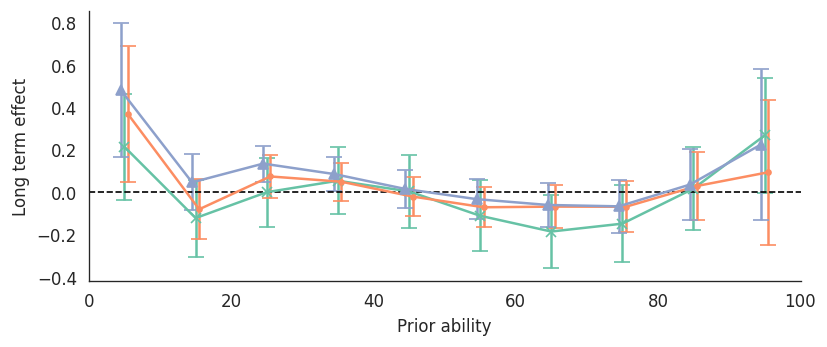

Saved figure -> ../output/plot_heterogeneous_z_score7_gau_rkhs.png
Rep: 1


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Rep: 1


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


[PLOT] Heterogeneous — RKHS — Outcome: z_score8 -> ../output/plot_heterogeneous_z_score8_gau_rkhs.png


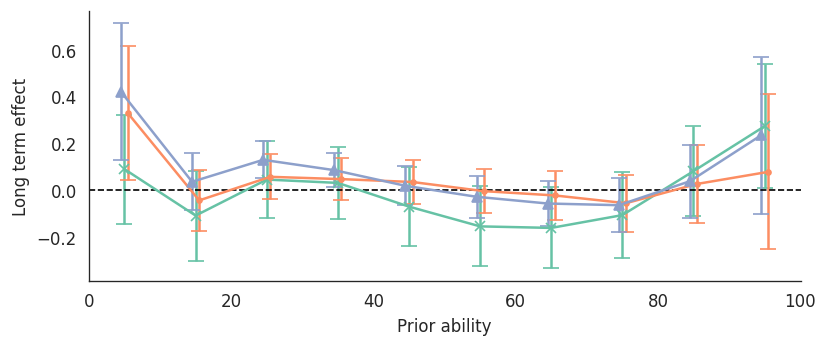

Saved figure -> ../output/plot_heterogeneous_z_score8_gau_rkhs.png
Saved heterogeneous (rkhs) -> ../output/heterogeneous_star_rkhs.csv
[TIMING] RKHS — Heterogeneous cate plots finished in 2m 41.41s


In [14]:

# ---- Run heterogeneous (CATE) for RKHS and NN ----
with timer("RKHS — Heterogeneous cate plots"):
    hetero_rkhs = run_heterogeneous_grid(
        df=df,
        outcome_cols=OUTCOME_LIST,
        mode="rkhs",
        loc_kernel="gau",
        percentiles=np.arange(5, 100, 10),
    )


Rep: 1


100%|██████████| 5/5 [12:58<00:00, 155.63s/it]


Rep: 1


100%|██████████| 5/5 [09:50<00:00, 118.10s/it]


[PLOT] Heterogeneous — NN — Outcome: z_score3 -> ../output/plot_heterogeneous_z_score3_gau_nn.png


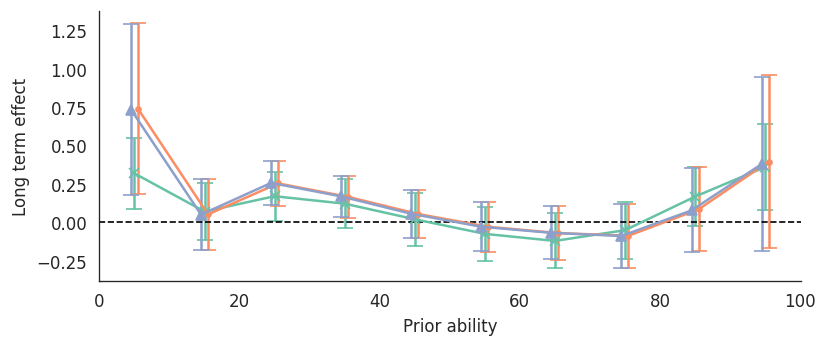

Saved figure -> ../output/plot_heterogeneous_z_score3_gau_nn.png
Rep: 1


100%|██████████| 5/5 [09:35<00:00, 115.18s/it]


Rep: 1


100%|██████████| 5/5 [10:13<00:00, 122.68s/it]


[PLOT] Heterogeneous — NN — Outcome: z_score4 -> ../output/plot_heterogeneous_z_score4_gau_nn.png


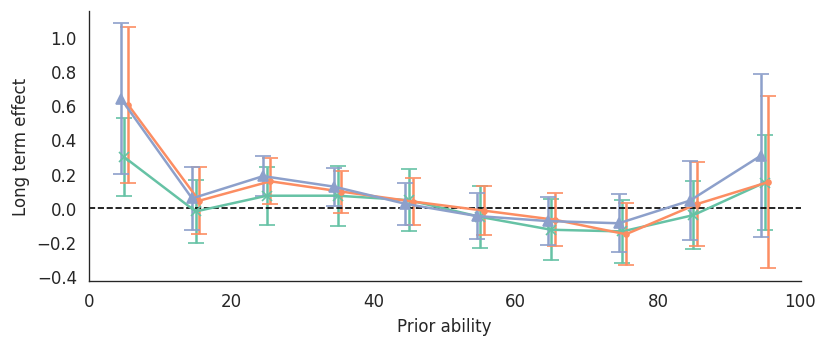

Saved figure -> ../output/plot_heterogeneous_z_score4_gau_nn.png
Rep: 1


100%|██████████| 5/5 [09:27<00:00, 113.60s/it]


Rep: 1


100%|██████████| 5/5 [09:52<00:00, 118.41s/it]


[PLOT] Heterogeneous — NN — Outcome: z_score5 -> ../output/plot_heterogeneous_z_score5_gau_nn.png


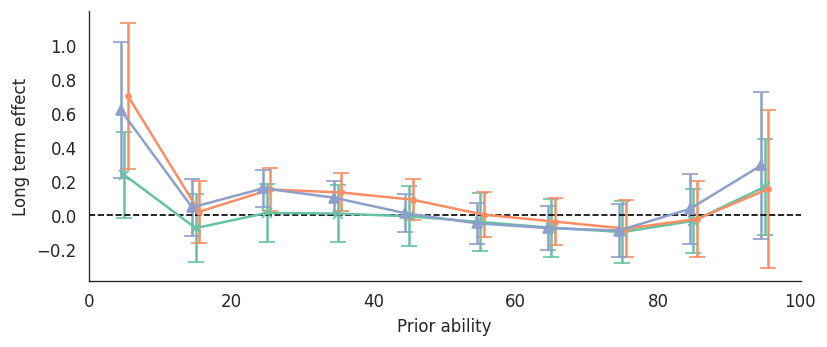

Saved figure -> ../output/plot_heterogeneous_z_score5_gau_nn.png
Rep: 1


100%|██████████| 5/5 [09:27<00:00, 113.41s/it]


Rep: 1


100%|██████████| 5/5 [09:47<00:00, 117.55s/it]


[PLOT] Heterogeneous — NN — Outcome: z_score6 -> ../output/plot_heterogeneous_z_score6_gau_nn.png


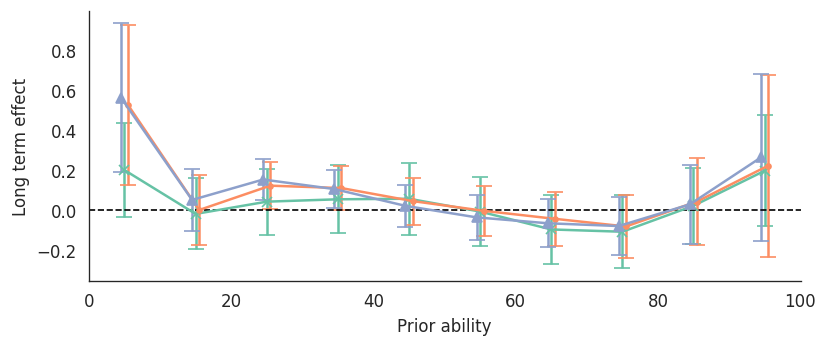

Saved figure -> ../output/plot_heterogeneous_z_score6_gau_nn.png
Rep: 1


100%|██████████| 5/5 [09:30<00:00, 114.18s/it]


Rep: 1


100%|██████████| 5/5 [09:53<00:00, 118.70s/it]


[PLOT] Heterogeneous — NN — Outcome: z_score7 -> ../output/plot_heterogeneous_z_score7_gau_nn.png


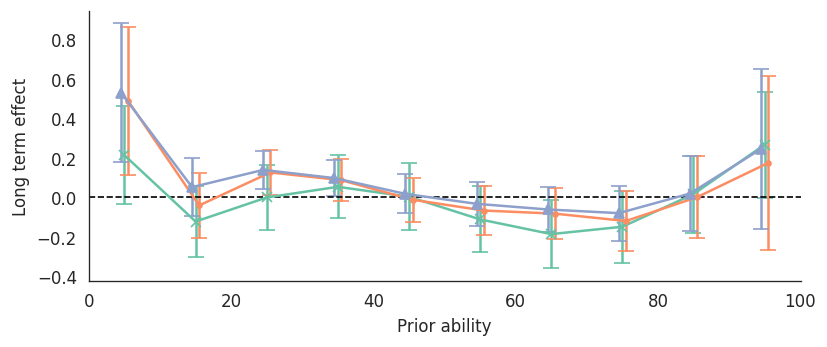

Saved figure -> ../output/plot_heterogeneous_z_score7_gau_nn.png
Rep: 1


100%|██████████| 5/5 [09:43<00:00, 116.75s/it]


Rep: 1


100%|██████████| 5/5 [09:52<00:00, 118.50s/it]


[PLOT] Heterogeneous — NN — Outcome: z_score8 -> ../output/plot_heterogeneous_z_score8_gau_nn.png


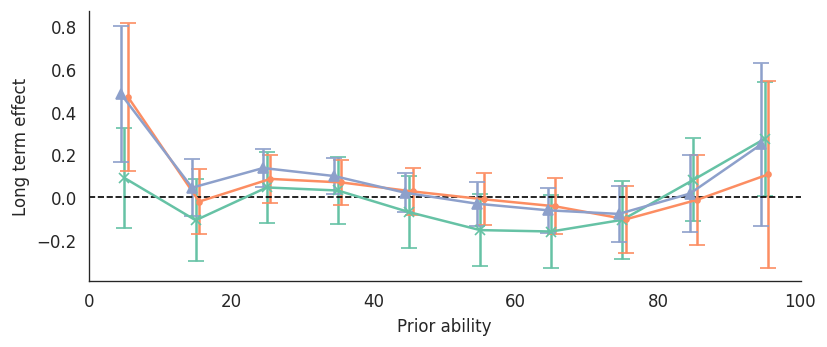

Saved figure -> ../output/plot_heterogeneous_z_score8_gau_nn.png
Saved heterogeneous (nn) -> ../output/heterogeneous_star_nn.csv
[TIMING] AGMM — Heterogeneous cate plots finished in 120m 19.42s


In [15]:

with timer("AGMM — Heterogeneous cate plots"):
    hetero_nn = run_heterogeneous_grid(
        df=df,
        outcome_cols=OUTCOME_LIST,
        mode="nn",
        loc_kernel="gau",
        percentiles=np.arange(5, 100, 10),
    )
